# RACE PACE ANALYSIS 

In [2]:
import fastf1
import fastf1.plotting 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import os

In [3]:
# 1. SETUP: Enable cache and styling
# Pointing to the 'data' folder we created in the root
fastf1.Cache.enable_cache(os.path.join("..", "data"))
fastf1.plotting.setup_mpl(mpl_timedelta_support=False, misc_mpl_mods=False)


# 2. DATA EXTRACTION: Target FP2 (Race Simulation Session)
session_abd = fastf1.get_session(2025, 'Abu Dhabi', 'FP2')
session_abd.load()

# 3. CLEANING: Get all laps and filter for "Clean Air" pace
# pick_quicklaps() removes laps > 107% of the fastest lap
# pick_wo_box() removes laps where the driver entered or exited the pits
laps= session_abd.laps.pick_quicklaps().pick_wo_box()

#Convert LapTime (timedelta) to seconds for the plot
laps['LapTime(s)']=laps['LapTime'].dt.total_seconds()

# 4. PREPARE THE DATA: Get top 10 finishers or specific drivers
drivers = session_abd.results['Abbreviation'].head(10).tolist()
plot_laps = laps[laps['Driver'].isin(drivers)]



c:\Users\trive\AppData\Local\Programs\Python\Python312\Lib\site-packages\fastf1\plotting\_plotting.py:57: FutureWarning: The `misc_mpl_mods` argument was dropped from `.setup_mpl()` in version 3.6.0 and has no effect anymore. It will be removed in a future version of FastF1.
  warnings.warn(
core           INFO 	Loading data for Abu Dhabi Grand Prix - Practice 2 [v3.7.0]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_ap

req            INFO 	Using cached data for driver_info


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\trive\\Desktop\\vaanishka\\Data Science\\f1_pred\\output\\race_pace_violin.png'

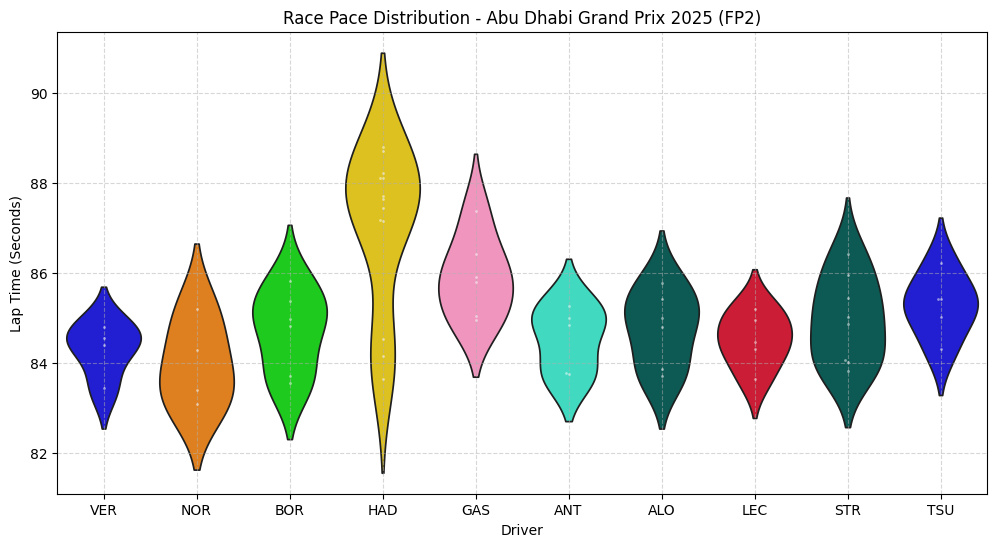

In [4]:

# 5. VISUALIZATION: Create the Violin Plot
plt.figure(figsize=(12, 6))

# Use the driver-to-color mapping for accuracy
driver_colors = fastf1.plotting.get_driver_color_mapping(session=session_abd)

sns.violinplot(
    data=plot_laps, 
    x='Driver', 
    y='LapTime(s)', 
    inner=None, 
    palette=driver_colors,
    hue='Driver',
    legend=False
)

# Overlay a swarm plot to see individual lap points
sns.swarmplot(data=plot_laps, x='Driver', y='LapTime(s)', color='white', size=2, alpha=0.5)

plt.title(f"Race Pace Distribution - {session_abd.event.EventName} 2025 (FP2)")
plt.ylabel("Lap Time (Seconds)")
plt.grid(visible=True, linestyle='--', alpha=0.5)

# Save the output to our 'outputs' folder
output_path = os.path.join('..', 'output', 'race_pace_violin.png')
plt.savefig(output_path)
plt.show()

print(f"Analysis complete. Plot saved to: {output_path}")


# LONG RUN DISTRBUTION

**SUMMARY:Lap Time vs. Driver**
&nbsp;&nbsp;&nbsp;&nbsp;This provides the model with a "Power Ranking" of who has the fastest car in race-trim.

-  **width** : concentration of laps; 
a wider section means many laps were completed at or around that time.

-**Pace:** A violin positioned lower (faster times) indicates better pace.


**CONTRIBUTION TO THE PRED MODEL**


Feature: "Performance Stability." The model uses the variance (height of the violin) to calculate the probability of a driver making a mistake or falling into a "DRS train" during the race.

In [ ]:
from ipywidgets import interact, SelectMultiple


# 1. Get a list of all unique drivers from the session results
all_drivers = sorted(session_abd.results['Abbreviation'].unique())

# 2. Create the interactive function
def plot_multi_driver_consistency(selected_drivers):
    if not selected_drivers:
        print("Please select at least one driver from the list.")
        return

    # Filter data for selected drivers
    comparison_laps = laps[laps['Driver'].isin(selected_drivers)].copy()
    
    plt.figure(figsize=(14, 7))
    
    # Get official colors
    driver_colors = fastf1.plotting.get_driver_color_mapping(session=session_abd)
    
    # Plotting: X is the Stint, Y is the LapTime, Hue is the Driver
    sns.violinplot(
        data=comparison_laps, 
        x='Stint', 
        y='LapTime(s)', 
        hue='Driver',
        palette=driver_colors,
        inner="quartile",
        gap=.1 # Adds a small gap between the violins for better visibility
    )

    plt.title(f"Pace Comparison per Stint: {', '.join(selected_drivers)}")
    plt.ylabel("Lap Time (Seconds)")
    plt.xlabel("Stint Number")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# 3. Display the Selection Box
# Hold 'Ctrl' (Windows) or 'Cmd' (Mac) to select multiple drivers at once
print("Hold Ctrl/Cmd to select multiple drivers:")
interact(plot_multi_driver_consistency, selected_drivers=SelectMultiple(options=all_drivers, value=['VER', 'HAM']))

NameError: name 'session_abd' is not defined

# Stint-Wise Evolution Plot

**SUMMARY .  (Lap Time vs. Stint)**
&nbsp;It answers: "How much slower did the driver get as the tires got older?
- **Vertical Shift:** If Stint 2’s violin is higher up the Y-axis than Stint 1, it visually confirms the "slow down" caused by tire wear.

- **"Skinny" Violin:** If a stint has a very thin, long violin, it means the driver had "dirty air" or high degradation.

- **"Fat" Violin:** If it's wide and short, the driver was in a perfect, consistent rhythm.

**ML CONTRIBUTION:** Provides the degradation factor for the model which represents the tire wearout and how it affects the final podium position.

c:\Users\trive\AppData\Local\Programs\Python\Python312\Lib\site-packages\fastf1\core.py:3081: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"


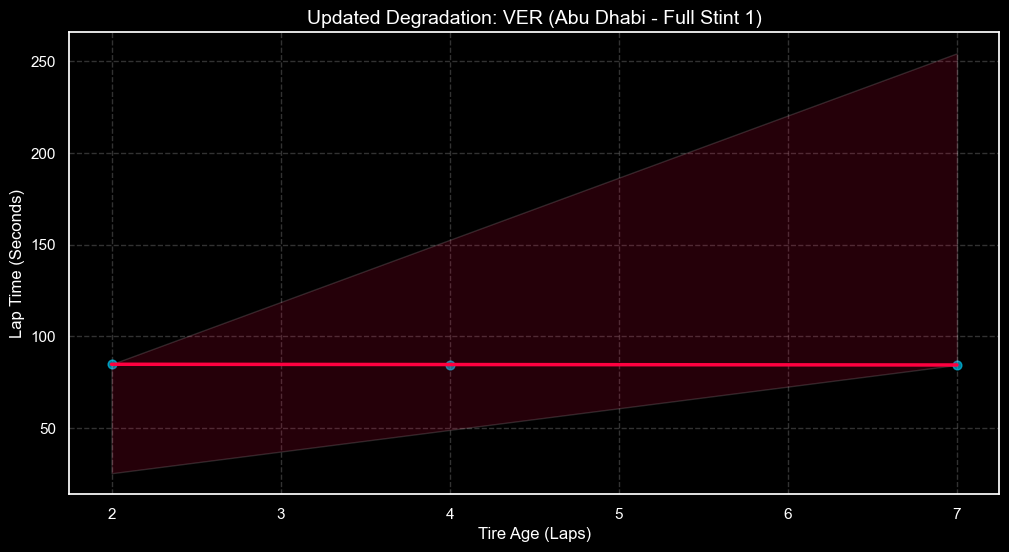

In [ ]:

# 1. Grab a larger chunk of data (e.g., the first 20 laps of the race)
# We use .query for a cleaner way to filter multiple conditions
stint_data = laps.pick_driver('VER').query("Stint == 1 & LapNumber < 20").copy()

# 2. Crucial Step: Filter out the 'Noise'
# We remove any lap that is 7% slower than the fastest lap in this stint 
# (This removes pit stops and Virtual Safety Cars)
fastest_lap = stint_data['LapTime(s)'].min()
clean_stint = stint_data[stint_data['LapTime(s)'] < fastest_lap * 1.07]

# 3. Re-Plotting with 'The Glow'
plt.style.use('dark_background')
plt.figure(figsize=(12, 6))

sns.regplot(
    data=clean_stint,
    x='TyreLife', 
    y='LapTime(s)',
    scatter_kws={'alpha':0.6, 's':40, 'color':'#00d2ff'}, 
    line_kws={'color':'#ff0040', 'lw':2.5},
    ci=95
)

plt.title("Updated Degradation: VER (Abu Dhabi - Full Stint 1)", fontsize=14)
plt.xlabel("Tire Age (Laps)", fontsize=12)
plt.ylabel("Lap Time (Seconds)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.2)

plt.show()

In [ ]:
from scipy import stats

# 1. Calculate the Linear Regression (The Math behind the Red Line)
# This uses the same 'clean_stint' we used for the plot
slope, intercept, r_value, p_value, std_err = stats.linregress(clean_stint['TyreLife'], clean_stint['LapTime(s)'])

# 2. Output the 'Degradation Number'
print(f"Driver: {clean_stint['Driver'].iloc[0]}")
print(f"Degradation Slope: {slope:.4f} seconds/lap")
print(f"Predictability (R-Squared): {r_value**2:.4f}")

Driver: VER
Degradation Slope: -0.0776 seconds/lap
Predictability (R-Squared): 0.9407


In [ ]:
import pandas as pd
from scipy import stats

# 1. Define the drivers we want to compare
drivers = ['VER', 'NOR', 'LEC']
results = []

for driver in drivers:
    # Get Stint 1 data for each driver
    stint_data = laps.pick_driver(driver).query("Stint == 1 & LapNumber < 20").copy()
    
    # Filter outliers (7% rule)
    fastest_lap = stint_data['LapTime(s)'].min()
    clean_stint = stint_data[stint_data['LapTime(s)'] < fastest_lap * 1.07]
    
    # Calculate the Math
    slope, intercept, r_value, p_value, std_err = stats.linregress(clean_stint['TyreLife'], clean_stint['LapTime(s)'])
    
    results.append({
        'Driver': driver,
        'Net_Slope': round(slope, 4),
        'Consistency(R2)': round(r_value**2, 4)
    })

# 2. View the Leaderboard
comparison_df = pd.DataFrame(results)
print(comparison_df.sort_values(by='Net_Slope'))

  Driver  Net_Slope  Consistency(R2)
1    NOR    -0.1830           1.0000
2    LEC    -0.0850           1.0000
0    VER    -0.0776           0.9407


c:\Users\trive\AppData\Local\Programs\Python\Python312\Lib\site-packages\fastf1\core.py:3081: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
c:\Users\trive\AppData\Local\Programs\Python\Python312\Lib\site-packages\fastf1\core.py:3081: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
c:\Users\trive\AppData\Local\Programs\Python\Python312\Lib\site-packages\fastf1\core.py:3081: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"


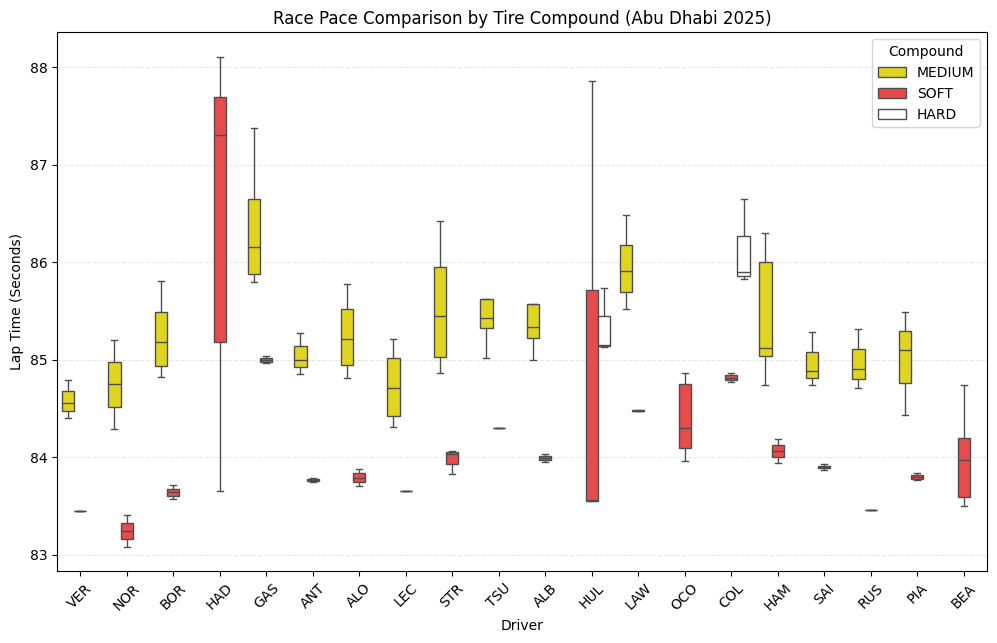

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Filter out the very slow laps (In-laps/Out-laps/Safety Car) 
# to keep the pace analysis 'pure'
clean_laps = laps[laps['LapTime(s)'] < laps['LapTime(s)'].quantile(0.95)]

plt.figure(figsize=(12, 7))

# 2. Plotting Lap Time vs Driver, colored by Tire Compound
sns.boxplot(
    data=clean_laps,
    x='Driver',
    y='LapTime(s)',
    hue='Compound',
    palette={'SOFT': '#FF3333', 'MEDIUM': '#FFF200', 'HARD': '#FFFFFF'},
    fliersize=0 # Hides outliers to keep the focus on the main pace
)

plt.title("Race Pace Comparison by Tire Compound (Abu Dhabi 2025)")
plt.ylabel("Lap Time (Seconds)")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.show()

# Tire Compound Comparision
The Box Plot (or Whisker Plot) is a statistical distribution summary the Box Plot focuses on the exact quartiles of the performance.

**The Median (Middle Line):** The most frequent "true pace" of the driver. It ignores the "lucky" fast laps and the "unlucky" slow laps.

**The Box (Interquartile Range):** 
- Represents the middle 50% of the driver's laps. 
- A **small box** means the driver is extremely consistent. 
- A **large box** means their pace is fluctuating wildly.

**The Whiskers:** Show the range of the fastest and slowest laps (excluding outliers).

**Outliers (Dots):** These represent laps where something unusual happened (mistakes, blue flags, or the "in-lap" before a pit stop).

Contribution to the ML Model: The Box Plot provides the model with the **"Pace Reliability"** score and **compound offset**. A driver with a very low median and a very tiny box is a "Low-Risk" prediction for a win.



# SUMMARY

A simple visualization of how lap times look across different tire compounds (Soft vs. Medium vs. Hard), why some drivers were faster in certain stints.

- The tire compound defines the "operating limits" of the car.

- Soft Tires: High grip, fast lap times, but very inconsistent as they overheat.

- Hard Tires: Lower grip, slower lap times, but highly consistent.

**The ML Impact:** If your model sees Verstappen doing a 1:30.0 on Hards and Hamilton doing a 1:30.0 on Softs, the model needs to know that Verstappen is actually "faster" in relative terms. Without the compound label, the model would think they are equal.


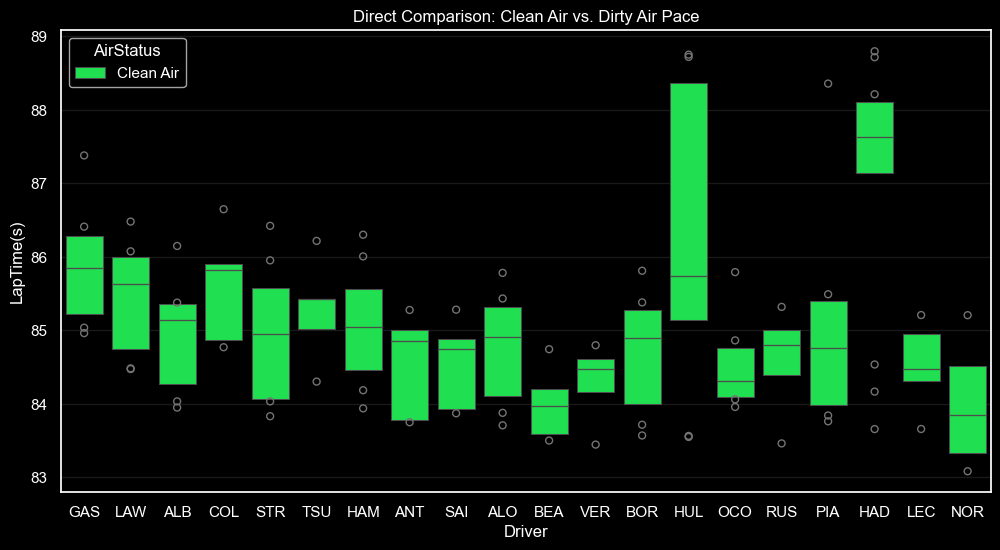

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# We use a boxenplot here—it's like a box plot but shows more 'levels' of data
plt.figure(figsize=(12, 6))
plt.style.use('dark_background')

sns.boxenplot(
    data=processed_laps, 
    x='Driver', 
    y='LapTime(s)', 
    hue='AirStatus', # THIS is what adds the Dirty Air representation
    palette={'Clean Air': '#00ff41', 'Dirty Air': '#ff0000'}
)

plt.title("Direct Comparison: Clean Air vs. Dirty Air Pace")
plt.grid(axis='y', alpha=0.1)
plt.show()

# Clean Air VS Dirty Air Effects:

C:\Users\trive\AppData\Local\Temp\ipykernel_9672\3465082044.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=clean_laps, x='Driver', y='LapTime(s)',


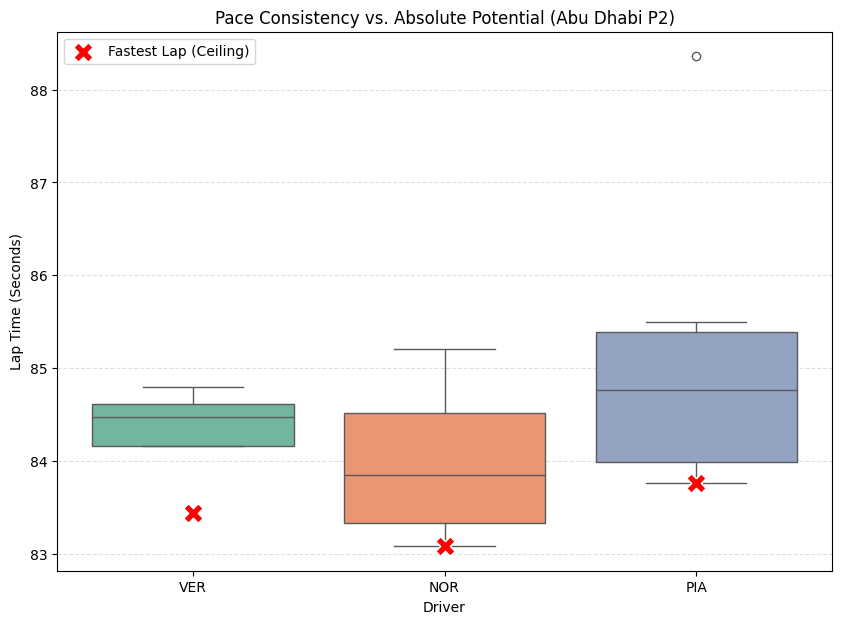

In [ ]:
def plot_pace_vs_ceiling(selected_drivers=['VER', 'NOR', 'PIA']):
    plt.close('all')
    
    # 1. Prepare Data
    laps = session_abd.laps.pick_drivers(selected_drivers).copy()
    laps['LapTime(s)'] = laps['LapTime'].dt.total_seconds()
    
    # Filter for representative pace (removing very slow laps)
    fastest_session_lap = laps['LapTime(s)'].min()
    clean_laps = laps[laps['LapTime(s)'] < fastest_session_lap * 1.07]

    # 2. Calculate the 'Ceiling' (Fastest Lap per Driver)
    ceilings = clean_laps.groupby('Driver')['LapTime(s)'].min().reset_index()

    # 3. Plotting
    plt.figure(figsize=(10, 7))
    
    # Main Boxplot for consistency and median
    sns.boxplot(data=clean_laps, x='Driver', y='LapTime(s)', 
                order=selected_drivers, palette='Set2', whis=1.5)
    
    # Overlay the 'Ceiling' as a scatter point
    sns.scatterplot(data=ceilings, x='Driver', y='LapTime(s)', 
                    marker='X', s=200, color='red', label='Fastest Lap (Ceiling)', zorder=5)

    plt.title("Pace Consistency vs. Absolute Potential (Abu Dhabi P2)")
    plt.ylabel("Lap Time (Seconds)")
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.legend()
    plt.show()

plot_pace_vs_ceiling()

# Performnce VS Potential 

**Max Verstappen: RACE MODE**
- This is "High-Confidence" data. 
- It tells the model that the Red Bull car is incredibly stable and that the driver isn't fighting the balance. 
- When the model sees this, it assigns a High Reliability Weight to the car's performance features.

**Lando Norris: The "Experimental Pushing**
- **"Sandbagging" Signal:** A large gap between the median (the line in the box) and the Red X often indicates a 
High Fuel Load simulation. 
- Even though he is "slow" on average, he "hooked up" one flying lap to show the car's true potential. lando hasd a heavy fuel load 
- **tall box (high IQR):** A tall box means the driver was not hitting the same lap time repeatedly.
- **very low Red X:** True potential of the car 
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;he is testing the "limits of the envelope."
**Model Impact:** It learns that the McLaren has a massive performance range depending on the fuel/engine map.

**Oscar Piastri: The "Learning Curve"**
- Inference: If Oscar’s Red X is higher than Lando's and his box is shifted upwards, he is struggling with the "representative" pace of the session.

- Teammate Delta: In your model, the gap between teammates is a "Skill Feature." If the car is identical, the model sees that Lando can extract more "Peak Pace" (lower X) than Oscar at this specific track.

# SECTOR ANALYSIS
**Sector 1 (Power & High Speed):** Turns 2-3. Tests engine and high-speed aero.

**Sector 2 (The Straights):** Two long DRS zones. Pure top speed and braking stability.

**Sector 3 (The Technical):** Tight, street-circuit style turns under the hotel. Tests mechanical grip and tire cooling.

c:\Users\trive\AppData\Local\Programs\Python\Python312\Lib\site-packages\fastf1\core.py:3081: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
c:\Users\trive\AppData\Local\Programs\Python\Python312\Lib\site-packages\fastf1\core.py:3081: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"


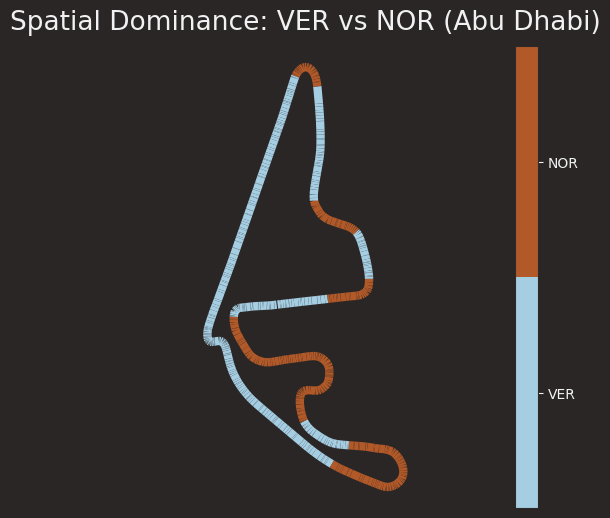

In [ ]:
import fastf1 as ff1
from fastf1 import plotting
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import numpy as np
import pandas as pd

# Setup plotting and cache
plotting.setup_mpl()

# 1. Load telemetry for the two fastest laps
# (Assuming session_abd is already loaded from your previous steps)
laps_ver = session_abd.laps.pick_driver('VER').pick_fastest()
laps_nor = session_abd.laps.pick_driver('NOR').pick_fastest()

telemetry_ver = laps_ver.get_telemetry().add_distance()
telemetry_nor = laps_nor.get_telemetry().add_distance()

# 2. Divide track into minisectors (e.g., 25 segments)
num_minisectors = 25
total_distance = max(telemetry_ver['Distance'].max(), telemetry_nor['Distance'].max())
minisector_length = total_distance / num_minisectors

# Assign each telemetry point to a minisector
telemetry_ver['Minisector'] =  telemetry_ver['Distance'].apply(
    lambda dist: int(dist // minisector_length) + 1
)
telemetry_nor['Minisector'] =  telemetry_nor['Distance'].apply(
    lambda dist: int(dist // minisector_length) + 1
)

# 3. Calculate average speed per driver per minisector
avg_speed_ver = telemetry_ver.groupby('Minisector')['Speed'].mean()
avg_speed_nor = telemetry_nor.groupby('Minisector')['Speed'].mean()

# Determine the winner (1 for VER, 2 for NOR)
fastest_driver = []
for i in range(1, num_minisectors + 1):
    if avg_speed_ver[i] > avg_speed_nor[i]:
        fastest_driver.append(1)
    else:
        fastest_driver.append(2)

# 4. Create the Map
x = telemetry_ver['X'].values
y = telemetry_ver['Y'].values
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Map winners back to the full telemetry for coloring
# (This step ensures every 'dot' on the line knows which color to be)
telemetry_ver['Fastest_int'] = telemetry_ver['Minisector'].apply(lambda m: fastest_driver[m-1] if m <= num_minisectors else fastest_driver[-1])

# 5. Plotting
fig, ax = plt.subplots(figsize=(6, 6))
cmap = plt.get_cmap('Paired', 2) # Use 2 distinct colors
lc = LineCollection(segments, cmap=cmap, linewidth=6)
lc.set_array(telemetry_ver['Fastest_int'].values)

ax.add_collection(lc)
ax.axis('equal')
ax.set_axis_off()

# Add a legend/colorbar
cbar = plt.colorbar(lc, ticks=[1.25, 1.75])
cbar.ax.set_yticklabels(['VER', 'NOR'])
plt.title("Spatial Dominance: VER vs NOR (Abu Dhabi)")
plt.show()

**Verstappen: The High-Speed Specialist**
Straight-Line Dominance: 
- Verstappen owns the massive Sector 2 straights. 
- This suggests superior aerodynamic efficiency and lower drag, or perhaps a higher engine mode during this specific run.

Braking Stability: He shows dominance at the end of the long straights, indicating late-braking confidence and a car that is stable under high-speed deceleration.

**Norris: The Cornering King**
Technical Superiority: Norris dominates the technical "Hotel Section" (Sector 3) and the tight hairpins. This indicates superior mechanical grip and a chassis that rotates better in low-speed corners.


**How this feeds your 2026 Model**
**Track Sensitivity:** The model now knows that on "Power Tracks" (like Monza or Vegas), 
- it should weigh Verstappen's characteristics more heavily. 
- Conversely, on "Technical Tracks" (like Monaco or Hungary), Norris is the statistical favorite.

**Overtaking Intelligence:** Because Verstappen is faster on the straights, the model predicts his primary overtaking method is DRS-assisted passes. Norris, being faster in the twists, is predicted to gain time in the Technical Infield to stay within the 1-second DRS window.

**Setup Detection:** If this was Practice, the model flags that Red Bull likely prioritized top speed while McLaren focused on downforce for tire preservation in the twisting sectors.

In [ ]:
import pandas as pd
import numpy as np

def calculate_consistency_metrics(driver_list):
    results = []
    
    for abr in driver_list:
        try:
            # 1. Fetch all valid laps for the driver
            laps = session_abd.laps.pick_drivers(abr).dropna(subset=['Sector1Time', 'Sector2Time', 'Sector3Time'])
            
            if laps.empty: continue

            # Convert to float seconds for calculation
            laps['S1'] = laps['Sector1Time'].dt.total_seconds()
            laps['S2'] = laps['Sector2Time'].dt.total_seconds()
            laps['S3'] = laps['Sector3Time'].dt.total_seconds()
            laps['Total'] = laps['LapTime'].dt.total_seconds()

            # 2. Rolling Best: The fastest ACTUAL lap completed in the session
            # (This ensures the S1, S2, and S3 were done back-to-back at 100% effort)
            rolling_best_lap = laps.loc[laps['Total'].idxmin()]
            rolling_best_time = rolling_best_lap['Total']

            # 3. Consistency Delta: Actual Mean Pace - Rolling Best
            # This shows how much "potential" is lost across a stint
            avg_pace = laps['Total'].mean()
            consistency_delta = avg_pace - rolling_best_time

            # 4. Overdriving Score (Standard Deviation of Sector Deltas)
            # High Score = Driver is 'peaking' in one sector but failing the next
            overdrive_score = laps[['S1', 'S2', 'S3']].std().mean()

            results.append({
                'Driver': abr,
                'Rolling Best': round(rolling_best_time, 3),
                'Avg Pace': round(avg_pace, 3),
                'Consistency Delta': round(consistency_delta, 3),
                'Overdrive Score': round(overdrive_score, 3)
            })
        except Exception as e:
            print(f"Error for {abr}: {e}")

    return pd.DataFrame(results).sort_values('Rolling Best')

# Execute for your contenders
consistency_report = calculate_consistency_metrics(['VER', 'NOR', 'LEC', 'HAM', 'PIA'])
print(consistency_report)


  Driver  Rolling Best  Avg Pace  Consistency Delta  Overdrive Score
1    NOR        83.083   104.343             21.260            8.543
0    VER        83.446    95.491             12.045            7.703
2    LEC        83.658   103.406             19.748           10.300
4    PIA        83.763   104.461             20.698            8.918
3    HAM        83.939    97.762             13.823           12.972


**1. Rolling Best:** 
- LapThe Rolling Best is the fastest actual lap a driver completed where all three sectors were performed consecutively in one continuous flow.
- Unlike an "Ideal Lap" (which is a "fantasy" sum of your best S1 from Lap 5 and best S3 from Lap 20) 
- the Rolling Best requires the driver to manage their ERS (Battery) and Tire Temps across the whole 5.2km of the track in one go.
- The Rolling Best ensures the performance was sustainable for at least one full lap.

**Model Impact:** For your 2026 model, the Rolling Best represents the true "Qualifying Ceiling"—the maximum pace the car can reach when everything is hooked up at once.


**2. Overdrive Score:** 
- It measures the variance (Standard Deviation) between a driver's sectors relative to their own best. 
- It detects if a driver is "fighting" the car or "flowing" with it.
- The Logic: If the score is high, the driver is inconsistent (pushing too hard in S1, ruining S3).

**Predictive Value:** For your 2026 model, a high Overdrive Score is a strong predictor for Tire Degradation and Unforced Errors during the race